## Embeddings

An embedding is a low-dimensional, vector representation of a (typically) high-dimensional feature which maintains the semantic meaning of the feature in a such a way that similar features are close in the embedding space.

In [32]:
import shutil
import os

import pandas as pd
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import callbacks, layers, models, utils
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow_hub import KerasLayer

### Embedding layer for categorical data

In [2]:
!head ./data/babyweight_sample.csv

weight_pounds,is_male,mother_age,plurality,gestation_weeks
5.2690480617999995,false,15,Single(1),28
6.37576861704,Unknown,15,Single(1),30
7.7492485093,true,42,Single(1),31
1.25002102554,true,14,Twins(2),25
8.68841774542,true,15,Single(1),31
1.25002102554,Unknown,42,Single(1),23
7.50012615324,true,15,Single(1),45
6.37576861704,true,15,Single(1),47
4.7509617461,true,42,Single(1),25


In [3]:
df = pd.read_csv("./data/babyweight_sample.csv") 
df.plurality.head(5)

0    Single(1)
1    Single(1)
2    Single(1)
3     Twins(2)
4    Single(1)
Name: plurality, dtype: object

In [4]:
df.plurality.unique()

array(['Single(1)', 'Twins(2)', 'Triplets(3)', 'Multiple(2+)',
       'Quadruplets(4)'], dtype=object)

In [5]:
CLASSES = {
    'Single(1)': 0,
    'Multiple(2+)': 1,
    'Twins(2)': 2,
    'Triplets(3)': 3,
    'Quadruplets(4)': 4,
    'Quintuplets(5)': 5
}
N_CLASSES = len(CLASSES)

Convert the plurality to a numeric index.

In [6]:
plurality_class = [CLASSES[plurality] for plurality in df.plurality]

In [7]:
print(df.plurality[:5])
print(plurality_class[:5])

0    Single(1)
1    Single(1)
2    Single(1)
3     Twins(2)
4    Single(1)
Name: plurality, dtype: object
[0, 0, 0, 2, 0]


Create an embedding layer. Supply arguments `input_dim` and `output_dim`
 - `input_dim` indicates the size of the vocabulary. For `plurality` this is 6.
 - `ouptut_dim` indicates the dimension of the dense embedding.

In [8]:
EMBED_DIM = 2

embedding_layer = layers.Embedding(input_dim=N_CLASSES,
                                   output_dim=EMBED_DIM)
embeds = embedding_layer(tf.constant(plurality_class))

The variable `embeds` contains the two-dimensional for each plurality class. 

In [9]:
embeds.shape

TensorShape([999, 2])

In [10]:
embeds[:5]

<tf.Tensor: shape=(5, 2), dtype=float32, numpy=
array([[ 0.00296154,  0.04679434],
       [ 0.00296154,  0.04679434],
       [ 0.00296154,  0.04679434],
       [ 0.03186324, -0.00946026],
       [ 0.00296154,  0.04679434]], dtype=float32)>

### Embedding Layers in a Keras model

In this section, we will implement text models to recognize the probable source (Github, Tech-Crunch, or The New-York Times) of the titles we have in the title dataset we constructed in the previous lab.

In a first step, we will load and pre-process the texts and labels so that they are suitable to be fed to a Keras model. For the texts of the titles we will learn how to split them into a list of tokens, and then how to map each token to an integer using the Keras Tokenizer class. What will be fed to our Keras models will be batches of padded list of integers representing the text. For the labels, we will learn how to one-hot-encode each of the 3 classes into a 3 dimensional basis vector.

Then we will explore a few possible models to do the title classification. All models will be fed padded list of integers, and all models will start with a Keras Embedding layer that transforms the integer representing the words into dense vectors.

Our model will be a simple bag-of-words DNN model that averages up the word vectors and feeds the tensor that results to further dense layers. Doing so means that we forget the word order (and hence that we consider sentences as a “bag-of-words”). Using an RNN or a 1-dimensional CNN would allow us to maintain the order of word embeddings in our model.

#### Load dataset

Let's start by specifying where the information about the trained models will be saved as well as where our dataset is located:

In [11]:
LOGDIR = "./text_models"
DATA_DIR = "./data"

Our dataset consists of titles of articles along with the label indicating from which source these articles have been taken from (GitHub, Tech-Crunch, or the New-York Times).

In [12]:
DATASET_NAME = "titles_full.csv"
TITLE_SAMPLE_PATH = os.path.join(DATA_DIR, DATASET_NAME)
COLUMNS = ['title', 'source']

titles_df = pd.read_csv(TITLE_SAMPLE_PATH, header=None, names=COLUMNS)
titles_df.head()

,title,source
0,holy cash cow batman - content is back,nytimes
1,show hn a simple and configurable deployment ...,github
2,show hn neural turing machine in pure numpy. ...,github
3,close look at a flu outbreak upends some commo...,nytimes
4,lambdalite a functional relational lisp data...,github


First, we'll find how many words we have in our dataset (`VOCAB_SIZE`), how many titles we have (`DATASET_SIZE`), and what the maximum length of the titles we have (`MAX_LEN`) is. Keras offers the `Tokenizer` class in its `keras.preprocessing.text` module to help us with this.

In [13]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(titles_df.title)
integerized_titles = tokenizer.texts_to_sequences(titles_df.title)

The variable 'integerized_titles' contains the integer representation of each article title in out dataset.

In [14]:
integerized_titles[:3]

[[6117, 560, 8577, 13948, 302, 13, 172],
 [11, 12, 2, 49, 7, 3838, 1322, 91, 4, 28, 482],
 [11, 12, 1501, 2812, 322, 5, 589, 7337, 5458, 78, 108, 1989, 17, 1139]]

From this and the `tokenizer` we can extract the `VOCAB_SIZE`, `DATASET_SIZE` and `MAX_LEN`.

In [15]:
VOCAB_SIZE = len(tokenizer.index_word)
VOCAB_SIZE

47271

In [16]:
DATASET_SIZE = tokenizer.document_count
DATASET_SIZE

96203

In [17]:
MAX_LEN = max(len(sequence) for sequence in integerized_titles)
MAX_LEN

26

#### Preprocess data
We'll need to pad the elements of our title to feed into the model. Keras has the helper functions `pad_sequence` for that on the top of the tokenizer methods.

The function `create_sequences` will 
* take as input our titles as well as the maximum sentence length and 
* returns a list of the integers corresponding to our tokens padded to the sentence maximum length

In [18]:
def create_sequences(texts, max_len=MAX_LEN):
    sequences = tokenizer.texts_to_sequences(texts)
    padded_sequences = pad_sequences(sequences,
                                     max_len,
                                     padding='post')
    return padded_sequences

In [19]:
sample_titles = create_sequences(["holy cash cow  batman - content is back",
                                 "close look at a flu outbreak upends some common wisdom"])
sample_titles

array([[ 6117,   560,  8577, 13948,   302,    13,   172,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0],
       [ 1030,   316,    23,     2,  3718,  7338, 13949,   214,   715,
         4581,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0]],
      dtype=int32)

Next, we'll convert our label to numeric, categorical variable.

In [20]:
CLASSES = {
    'github': 0,
    'nytimes': 1,
    'techcrunch': 2
}
N_CLASSES = len(CLASSES)

In [21]:
def encode_labels(sources):
    classes = [CLASSES[source] for source in sources]
    one_hots = utils.to_categorical(classes)
    return one_hots

Create train/validation split

In [22]:
N_TRAIN = int(DATASET_SIZE * 0.80)

titles_df = pd.read_csv(TITLE_SAMPLE_PATH, header=None, names=COLUMNS)
titles_train, sources_train = (
    titles_df.title[:N_TRAIN], titles_df.source[:N_TRAIN])

titles_valid, sources_valid = (
    titles_df.title[N_TRAIN:], titles_df.source[N_TRAIN:])

In [23]:
sources_train.value_counts()

github        29175
techcrunch    24784
nytimes       23003
Name: source, dtype: int64

Then, prepare the data for the model. 

In [24]:
X_train, Y_train = create_sequences(titles_train), encode_labels(sources_train)
X_valid, Y_valid = create_sequences(titles_valid), encode_labels(sources_valid)

In [25]:
X_train[:3], Y_train[:3]

(array([[ 6117,   560,  8577, 13948,   302,    13,   172,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0],
        [   11,    12,     2,    49,     7,  3838,  1322,    91,     4,
            28,   482,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0],
        [   11,    12,  1501,  2812,   322,     5,   589,  7337,  5458,
            78,   108,  1989,    17,  1139,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0]],
       dtype=int32),
 array([[0., 1., 0.],
        [1., 0., 0.],
        [1., 0., 0.]], dtype=float32))

#### Build a DNN model

The `build_dnn_model` function below returns a compiled Keras model that implements a simple embedding layer transforming the word integers into dense vectors, followed by a Dense softmax layer that returns the probabilities for each class.


Note that we need to put a custom Keras Lambda layer in between the Embedding layer and the Dense softmax layer to do an average of the word vectors returned by the embedding layer. This is the average that's fed to the dense softmax layer. By doing so, we create a model that is simple but that loses information about the word order, creating a model that sees sentences as "bag-of-words".

In [29]:
def build_dnn_model(embed_dim):

    model = models.Sequential([
        layers.Embedding(VOCAB_SIZE + 1,
                         embed_dim,
                         input_shape=[MAX_LEN]),
        layers.Lambda(lambda x: tf.reduce_mean(x, axis=1)),
        layers.Dense(N_CLASSES, activation='softmax')
    ])

    model.compile(
        optimizer='adam',
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    return model

In [30]:
Y_train.shape

(76962, 3)

Train on 76962 samples, validate on 19241 samples
Epoch 1/100
76962/76962 [==============================] - 3s 43us/sample - loss: 1.0480 - accuracy: 0.4290 - val_loss: 0.9778 - val_accuracy: 0.5822
Epoch 2/100
76962/76962 [==============================] - 2s 27us/sample - loss: 0.8877 - accuracy: 0.6848 - val_loss: 0.8051 - val_accuracy: 0.7366
Epoch 3/100
76962/76962 [==============================] - 2s 27us/sample - loss: 0.7342 - accuracy: 0.7832 - val_loss: 0.6821 - val_accuracy: 0.7891
Epoch 4/100
76962/76962 [==============================] - 2s 27us/sample - loss: 0.6254 - accuracy: 0.8138 - val_loss: 0.5948 - val_accuracy: 0.8104
Epoch 5/100
76962/76962 [==============================] - 2s 27us/sample - loss: 0.5453 - accuracy: 0.8310 - val_loss: 0.5322 - val_accuracy: 0.8197
Epoch 6/100
76962/76962 [==============================] - 2s 27us/sample - loss: 0.4865 - accuracy: 0.8433 - val_loss: 0.4882 - val_accuracy: 0.8241
Epoch 7/100
76962/76962 [=========================

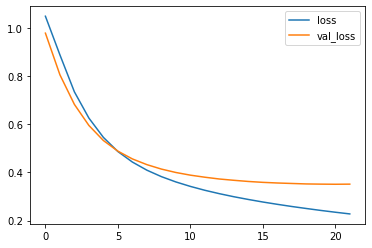

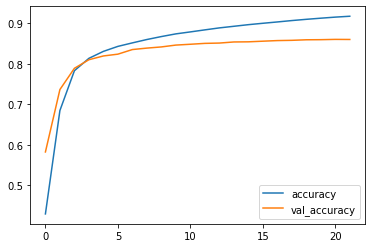

In [31]:
%%time

tf.random.set_seed(33)

MODEL_DIR = os.path.join(LOGDIR, 'dnn')
shutil.rmtree(MODEL_DIR, ignore_errors=True)

BATCH_SIZE = 300
EPOCHS = 100
EMBED_DIM = 10
PATIENCE = 0

dnn_model = build_dnn_model(embed_dim=EMBED_DIM)

dnn_history = dnn_model.fit(
    X_train, Y_train,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    validation_data=(X_valid, Y_valid),
    callbacks=[callbacks.EarlyStopping(patience=PATIENCE),
               callbacks.TensorBoard(MODEL_DIR)],
)

pd.DataFrame(dnn_history.history)[['loss', 'val_loss']].plot()
pd.DataFrame(dnn_history.history)[['accuracy', 'val_accuracy']].plot()

dnn_model.summary()

### Transfer Learning with Pre-trained Embedding

We can also use a word embedding from a pre-trained modle using a [Neural Probabilistic Language Model](http://www.jmlr.org/papers/volume3/bengio03a/bengio03a.pdf). TF-Hub has a 50-dimensional one called 
[nnlm-en-dim50-with-normalization](https://tfhub.dev/google/tf2-preview/nnlm-en-dim50/1), which also normalizes the vectors produced. 

Once loaded from its url, the TF-hub module can be used as a normal Keras layer in a sequential or functional model. Since we have enough data to fine-tune the parameters of the pre-trained embedding itself, we will set `trainable=True` in the `KerasLayer` that loads the pre-trained embedding:

In [30]:
NNLM = "https://tfhub.dev/google/nnlm-en-dim50/2"

nnlm_module = KerasLayer(
    handle=NNLM,
    output_shape=[50],
    input_shape=[],
    dtype=tf.string,
    trainable=True)

With this module, we do not need to pad our inputs. The NNLM module returns a 50-dimensional vector given a word or sentence. 

In [31]:
nnlm_module(tf.constant(["holy cash cow  batman - content is back",
                         "close look at a flu outbreak upends some common wisdom"]))

<tf.Tensor: shape=(2, 50), dtype=float32, numpy=
array([[ 0.0958989 , -0.34283403, -0.0492865 , -0.09070477,  0.15877678,
        -0.2123544 ,  0.28213888, -0.02812295, -0.07855891, -0.13102815,
         0.11162009,  0.00899508,  0.01711924,  0.3225362 , -0.13289747,
         0.11935385,  0.04386025,  0.06534779,  0.2200468 , -0.13539287,
        -0.0296053 , -0.06080014,  0.12862371,  0.23304917, -0.04424817,
         0.07436227, -0.1898077 , -0.13270935,  0.21959059,  0.10597934,
         0.03580458,  0.14275002, -0.06624421, -0.3247055 ,  0.04618761,
        -0.11603005,  0.06651008,  0.10887001, -0.05413236, -0.07126983,
         0.02225055,  0.2645486 , -0.04697315,  0.06729111, -0.14438024,
         0.06355232, -0.05749882, -0.04587579,  0.23790349,  0.258379  ],
       [ 0.11347695, -0.04064287,  0.1053718 , -0.2368139 , -0.08755025,
        -0.29770336, -0.00098698,  0.2312349 , -0.05596383,  0.04687293,
         0.07230621, -0.10018747,  0.17597003, -0.04471372, -0.16409421,
 

With this in mind, we can simplify our data inputs since do not need to integerize or pad. 

In [32]:
X_train, Y_train = titles_train.values, encode_labels(sources_train)
X_valid, Y_valid = titles_valid.values, encode_labels(sources_valid)

In [33]:
X_train[:3]

array(['holy cash cow  batman - content is back',
       'show hn  a simple and configurable deployment tool for github projects',
       'show hn  neural turing machine in pure numpy. implements all 5 tasks from paper'],
      dtype=object)

#### Build DNN model using TF-Hub Embedding layer

Next, we can add this TF-Hub module to our DNN model. 

In [34]:
def build_hub_model():
    model = models.Sequential([
        KerasLayer(handle=NNLM,
                   output_shape=[50],
                   input_shape=[],
                   dtype=tf.string,
                   trainable=True),
        layers.Dense(N_CLASSES, activation='softmax')
    ])

    model.compile(
        optimizer='adam',
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    return model

Train on 76962 samples, validate on 19241 samples
Epoch 1/100
76962/76962 [==============================] - 13s 168us/sample - loss: 0.7125 - accuracy: 0.7258 - val_loss: 0.4898 - val_accuracy: 0.8121
Epoch 2/100
76962/76962 [==============================] - 12s 156us/sample - loss: 0.4067 - accuracy: 0.8485 - val_loss: 0.4012 - val_accuracy: 0.8404
Epoch 3/100
76962/76962 [==============================] - 12s 156us/sample - loss: 0.3231 - accuracy: 0.8793 - val_loss: 0.3818 - val_accuracy: 0.8435
Epoch 4/100
76962/76962 [==============================] - 12s 156us/sample - loss: 0.2763 - accuracy: 0.8979 - val_loss: 0.3825 - val_accuracy: 0.8445
Epoch 5/100
76962/76962 [==============================] - 12s 156us/sample - loss: 0.2437 - accuracy: 0.9107 - val_loss: 0.3925 - val_accuracy: 0.8428
Epoch 6/100
76962/76962 [==============================] - 12s 154us/sample - loss: 0.2194 - accuracy: 0.9205 - val_loss: 0.4084 - val_accuracy: 0.8400
Model: "sequential_4"
________________

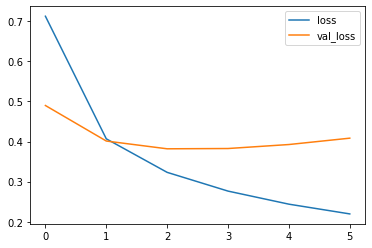

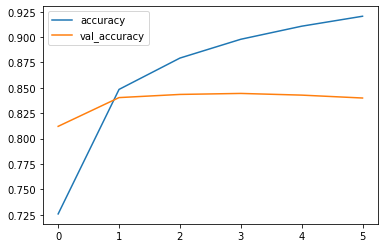

In [38]:
%%time

tf.random.set_seed(33)

MODEL_DIR = os.path.join(LOGDIR, 'hub')
shutil.rmtree(MODEL_DIR, ignore_errors=True)

BATCH_SIZE = 300
EPOCHS = 100
EMBED_DIM = 10
PATIENCE = 3

hub_model = build_hub_model()

hub_history = hub_model.fit(
    X_train, Y_train,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    validation_data=(X_valid, Y_valid),
    callbacks=[callbacks.EarlyStopping(patience=PATIENCE),
               callbacks.TensorBoard(MODEL_DIR)],
)

pd.DataFrame(hub_history.history)[['loss', 'val_loss']].plot()
pd.DataFrame(hub_history.history)[['accuracy', 'val_accuracy']].plot()

hub_model.summary()

Copyright 2020 Google Inc. Licensed under the Apache License, Version 2.0 (the "License"); you may not use this file except in compliance with the License. You may obtain a copy of the License at http://www.apache.org/licenses/LICENSE-2.0 Unless required by applicable law or agreed to in writing, software distributed under the License is distributed on an "AS IS" BASIS, WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied. See the License for the specific language governing permissions and limitations under the License